In [1]:
import pandas as pd
import numpy as np
import sklearn
import torch
import matplotlib.pyplot as plt

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

DESCRIPTIVES

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


(array([ 591.,  649., 2089., 1976., 1350.,  893.,  536.,  294.,  106.,
          30.]),
 array([ 0. ,  7.9, 15.8, 23.7, 31.6, 39.5, 47.4, 55.3, 63.2, 71.1, 79. ]),
 <BarContainer object of 10 artists>)

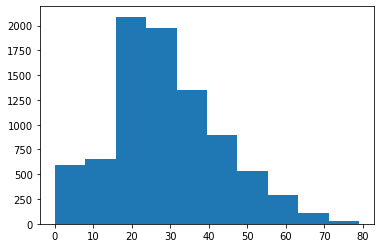

In [4]:
plt.hist(df_train.Age)

In [5]:
for column in df_train.columns[1:]:
    values = df_train[column].value_counts()
    if len(values) < 5:
        print(column, dict(values))
    else:
        print(f'{column} has {len(values)} different values')

HomePlanet {'Earth': 4602, 'Europa': 2131, 'Mars': 1759}
CryoSleep {False: 5439, True: 3037}
Cabin has 6560 different values
Destination {'TRAPPIST-1e': 5915, '55 Cancri e': 1800, 'PSO J318.5-22': 796}
Age has 80 different values
VIP {False: 8291, True: 199}
RoomService has 1273 different values
FoodCourt has 1507 different values
ShoppingMall has 1115 different values
Spa has 1327 different values
VRDeck has 1306 different values
Name has 8473 different values
Transported {True: 4378, False: 4315}


PREPROCESSING

In [6]:
def fillna_with_mode(df):
    for column in df.columns:
        mode_value = df[column].mode()[0]
        df[column].fillna(mode_value, inplace=True)
        
    return df

def replace_with_numbers(df, column_names):
    for column in column_names:
        unique_values = sorted(df[column].unique())
        value_to_number = {value: i for i, value in enumerate(unique_values)}
        df[column] = df[column].replace(value_to_number)
    
    return df

def get_non_numeric_columns(df):
    non_numeric_columns = []
    
    for column in df.columns:
        if not pd.api.types.is_numeric_dtype(df[column]) or pd.api.types.is_bool_dtype(df[column]):
            non_numeric_columns.append(column)

    return non_numeric_columns

In [17]:
non_numeric_columns = get_non_numeric_columns(df_train)
del non_numeric_columns[-2]
non_numeric_columns

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'VIP',
 'Transported']

In [29]:
df_test = fillna_with_mode(df_test)
df_train = fillna_with_mode(df_train)

df_test = replace_with_numbers(df_test, non_numeric_columns[:-1])
df_train = replace_with_numbers(df_train, non_numeric_columns)

In [32]:
df_train[:5]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0,1,0,149,2,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0
1,1,0,0,2184,2,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1
2,2,1,0,1,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0
3,3,1,0,1,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0
4,4,0,0,2186,2,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1


In [34]:
X = df_train[['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]
y = df_train['Transported']

PREDICTING

In [41]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=2, shuffle=True)

In [42]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

clf_SVC = SVC(C=10)
cvs = cross_val_score(clf_SVC, X, y, cv=kfold)
cvs.mean(), cvs.std()

(0.7854597343582718, 0.0014707764562703618)

In [43]:
from sklearn.ensemble import RandomForestClassifier

clf_RF = RandomForestClassifier(max_depth=8)
cvs = cross_val_score(clf_RF, X, y, cv=kfold)
cvs.mean(), cvs.std()

(0.7974229864373725, 0.001978899921035615)